![PandaLyze](https://github.com/Fluffy-Fatec/Projeto-Integrador-Imagem-Classificador/raw/develop/Imagens/pandalyzeheader.jpg)

# Challenge Description
At the heart of the digital age, where each interaction leaves a digital footprint, emerges the critical need to not only collect but deeply understand customer voices. Online reviews have become a treasure trove of insights, reflecting satisfaction, expectations, and sometimes disappointments of consumers. This project aims to go beyond mere data collection, proposing the construction of a sophisticated platform that integrates state-of-the-art sentiment analysis, storage in non-relational databases, and cutting-edge technology to decipher, map, and visualize these sentiments scattered across the digital world in a real and tangible geographic context.

This system will not only offer companies an accurate barometer of customer perception in different geographical areas but also enable a granular analysis of sentiment variations associated with local cultures, specific events, or product launches. By unraveling these complex and multifaceted patterns, companies will be able to adjust their marketing strategies, product development, and customer service with unprecedented precision, turning raw data into a directional compass for innovation and growth.

<b>Moreover, the application plans to employ advanced machine learning algorithms and natural language processing to not only classify reviews into basic sentiment categories but also to identify nuances and subtrends within these categories, offering an additional layer of insights. Combined with an intuitive user interface and a dynamic data visualization system, the project aims to create an invaluable tool for data-driven decision-making, allowing companies to visualize and react to customer feedback in real-time with detailed geographical resolution.</b>

The expectation is that this platform will become a fundamental instrument for companies seeking not only to survive but to thrive in the digital economy, proactively adapting to changes in customer perceptions and preferences. By providing a deep and actionable understanding of customer sentiment, this project aspires to inaugurate a new era of customer engagement, where decisions are driven by a holistic and geographically contextualized understanding of the customer experience.

This challenge represents a confluence of technology, data analysis, and business strategy, designed to equip companies with the knowledge necessary to anticipate customer needs, optimize user experience, and ultimately forge a stronger and more meaningful bond with their consumers worldwide.

# About Dataframe for Training

### Brazilian E-Commerce Public Dataset by Olist

Welcome! This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

Link: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

### Data Schema

![Schema](https://github.com/Fluffy-Fatec/Projeto-Integrador-Imagem-Classificador/raw/develop/Imagens/schema.png)

#### Dataframe Used for Training:
- olist_order_reviews_dataset.csv
##### Columns
- review_score: score entered by the user from 1 to 5, was used to previously classify whether the text was positive or negative for AI training, 1 and 2 equal Negative and 4 and 5 equal Positive.
- review_comment_title: title entered by the user referring to the product, was used alongside the text as it contains relevant information.
- review_comment_message: message field where the user enters the text referring to the product.

# 1. Install PIP's

In [3]:
%pip install unidecode
%pip install spacy
%pip install seaborn
%pip install nltk
%pip install stats
%pip install xgboost
%pip install sweetviz
%pip install string
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement string (from versions: none)
ERROR: No matching distribution found for string


# 2. Import Packages

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
nlp = spacy.load('pt_core_news_lg')
import string
import regex as re
from unidecode import unidecode
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE

# 3. Load Data

In [5]:
df = pd.read_csv("olist_order_reviews_dataset.csv")

# 4. Data Wreangling

### 4.1. Selected Columns Important

In [6]:
selected_columns = ['review_id','review_score', 'review_comment_title', 
                    'review_comment_message', 'review_creation_date']

full_df = df.loc[:, selected_columns]

### 4.2. Conversion Columns Data in datetime

In [7]:
datetime_columns = ['review_creation_date']
full_df[datetime_columns] = full_df[datetime_columns].apply(pd.to_datetime)

### 4.3. Division DF for Training

In [8]:
latest_date = full_df['review_creation_date'].max()
four_months_ago = latest_date - pd.DateOffset(months=1)


full_df = full_df[full_df['review_creation_date'] < four_months_ago]
full_df.reset_index(drop=True, inplace=True)

In [9]:
print(full_df.shape)

(89846, 5)


### 4.4. Drop Duplicates

In [10]:
full_df = full_df.drop_duplicates(subset=['review_id'])

In [11]:
print(full_df.shape)

(89082, 5)


### 4.5. Merge Title with Message

In [12]:
full_df['review_comment_title'] = full_df['review_comment_title'].fillna('').astype(str)
full_df['text_sentiment'] = full_df['review_comment_title'].str.cat(full_df['review_comment_message'], sep=' ')

In [13]:
print(full_df.shape)

(89082, 6)


### 4.6. Drop NA

In [14]:
full_df = full_df.dropna(subset=['text_sentiment'])
full_df = full_df.dropna(subset=['review_score'])

In [15]:
print(full_df.shape)

(37050, 6)


### 4.7. Take all different 3

In [16]:
full_df = full_df[full_df['review_score'] != 3]

In [17]:
print(len(full_df))

33816


# 5. Data Processing

### 5.1. Conversion Column Message in Lower Case

In [18]:
def to_lower(text):
    return text.lower()

In [19]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(to_lower)

### 5.2. Removing Punctuation, Exemple (".", "!")

In [20]:
def remove_punctuation(text):
    punct = string.punctuation
    punct = punct.replace("'", "")
    translator = str.maketrans('', '', punct)
    return text.translate(translator)

In [21]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_punctuation)

### 5.3. Removing Emoji

In [22]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # simbol and pictogramas
                               u"\U0001F680-\U0001F6FF"  # transport and ]simbol of map
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [23]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_emojis)

### 5.4. Removing Sites and Blogs

In [24]:
def remove_urls(text):
    http = r"http\S+|www\.\S+"
    pattern = re.compile(r"({})".format(http))
    return pattern.sub(r'', text)

In [25]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_urls)

### 5.5. Removing Accentuation

In [26]:
def remove_accent(text):
    return unidecode(text)

In [27]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_accent)

### 5.6. Remove Numbers

In [28]:
def remove_numbers(texto):
    return re.sub(r'\d+', '', texto)

In [29]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_numbers)

### 5.7. Remove Space Blank Excessive and Remove Broke Line

In [30]:
def remove_broke_line(texto):
    return texto.replace('\n', ' ')

In [31]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_broke_line)

### 5.8. Remove Blank Space Text

In [32]:
def strip_text(text):
    return text.strip()

In [33]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(strip_text)

### 5.9. Filter only Adjectives, Verbs, Noun, Adverbs and "nao" "nada"

In [34]:
def filtrar_tokens(text):
    doc = nlp(text)
    tokens_filtrados = []
    for token in doc:
        if token.text.lower() == 'nao':
            tokens_filtrados.append(token.text)
        elif token.text.lower() == 'nada':
            tokens_filtrados.append(token.text)
        elif token.pos_ in ['ADJ', 'VERB', 'NOUN', 'ADV']:
            tokens_filtrados.append(token.text)
    return ' '.join(tokens_filtrados)

In [35]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(filtrar_tokens)

### 5.10. Lematization Example: "entrega" change for "entregar"

In [36]:
def lemmatize_text(text):
    return " ".join([token.lemma_ for token in nlp(text)])

In [37]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(lemmatize_text)

### 5.11. Remove the word "Produto"

In [38]:
def remove_word(text, word):
    return text.replace(word, '')

In [39]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(lambda x: remove_word(x, 'produto'))

### 5.12. Drop NA

In [40]:
full_df = full_df.dropna(subset=['text_sentiment'])

In [41]:
print(len(full_df))

33816


In [42]:
full_df.head(5)

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,text_sentiment
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,2017-04-21,receber bem antes prazo estipular
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,parabem loja adorar comprar seguro pratico par...
8,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22,recomender aparelho eficiente site marcar apar...
11,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16,Travandopelo valor boa
14,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23,super recomendir vendedor confiavel ok entreg...


# 6. Previus Analyze

In [43]:
def df_metadata(df):
    metadata = pd.DataFrame(df.dtypes, columns=['dtypes'])
    metadata = metadata.reset_index()
    metadata['Column'] = metadata['index']
    metadata = metadata[['Column', 'dtypes']]
    metadata['# Missing'] = df.isnull().sum().values    
    metadata['# Unique'] = df.nunique().values
    
    # Verificar se o DataFrame não está vazio
    if not df.empty:
        metadata['Example'] = df.iloc[0].values
    else:
        metadata['Example'] = None
    
    return metadata

# Aplicar a função ao DataFrame
df_metadata(full_df)

,Column,dtypes,# Missing,# Unique,Example
0,review_id,object,0,33816,e64fb393e7b32834bb789ff8bb30750e
1,review_score,int64,0,4,5
2,review_comment_title,object,0,2821,
3,review_comment_message,object,0,30100,Recebi bem antes do prazo estipulado.
4,review_creation_date,datetime64[ns],0,590,2017-04-21 00:00:00
5,text_sentiment,object,0,27344,receber bem antes prazo estipular


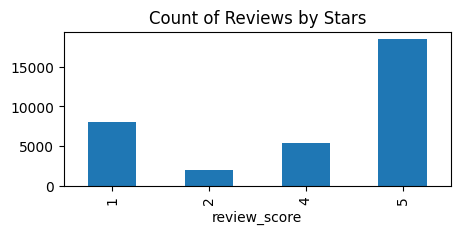

In [44]:
ax = full_df['review_score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(5,2))

In [45]:
example = full_df['text_sentiment'].iloc[4]
print(example)

super recomendir vendedor confiavel  ok entregar antes prazo


# 7. Training Model

### 7.1. Capture df_train

In [46]:
df_train = full_df.copy()

### 7.2. Classifier Review Score Negative with 0 (Review 1 or 2) and Positive with 1 (Review 3,4 or 5)

In [47]:
df_train['sentiment'] = df_train['review_score'].apply(lambda x: 0 if x in [1,2] else 1)

In [48]:
df_train.head(5)

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,text_sentiment,sentiment
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,2017-04-21,receber bem antes prazo estipular,1
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,parabem loja adorar comprar seguro pratico par...,1
8,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22,recomender aparelho eficiente site marcar apar...,1
11,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16,Travandopelo valor boa,1
14,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23,super recomendir vendedor confiavel ok entreg...,1


### 7.3. Selecting Columns Necessary for Training

In [49]:
selected_columns = ['text_sentiment', 'sentiment']
df_classification = df_train.loc[:, selected_columns]

In [50]:
df_classification.head(5)

,text_sentiment,sentiment
3,receber bem antes prazo estipular,1
4,parabem loja adorar comprar seguro pratico par...,1
8,recomender aparelho eficiente site marcar apar...,1
11,Travandopelo valor boa,1
14,super recomendir vendedor confiavel ok entreg...,1


### 7.4. Divising Dataframe Between Train and Test

In [51]:
comment_train, comment_test, sentiment_train, sentiment_test = train_test_split(
                                                                                df_classification['text_sentiment'],
                                                                                df_classification['sentiment'], 
                                                                                test_size=0.2,
                                                                                random_state=24)

### 7.5. Transform Text in Representation Numeric (TF-IDF)

In [52]:
vectorizer = TfidfVectorizer()

In [53]:
ctmTr = vectorizer.fit_transform(comment_train)
comment_test_dtm = vectorizer.transform(comment_test)

### 7.6 Creating New Words for Balance Negative and Positive

In [54]:
smote = SMOTE(random_state=42)
ctmTr_resampled, sentiment_train_resampled = smote.fit_resample(ctmTr, sentiment_train)

In [55]:
print(pd.Series(sentiment_train_resampled).value_counts())

sentiment
1    19149
0    19149
Name: count, dtype: int64


### 7.7. Calculing the Mean and Standard Deviation

In [56]:
normalization = preprocessing.StandardScaler(with_mean=False)

In [57]:
normalization.fit(ctmTr_resampled)
X = normalization.transform(ctmTr_resampled)

### 7.8. Inicializing Training NLP

In [58]:
analyze_sentiment = MLPClassifier(hidden_layer_sizes=(32,16,16,1),
                                   activation='relu',
                                   solver='adam',
                                   learning_rate='constant',
                                   max_iter=1000,
                                   early_stopping=True,
                                   n_iter_no_change=25,
                                   verbose=True)

history = analyze_sentiment.fit(X, sentiment_train_resampled)

Iteration 1, loss = 0.40799364
Validation score: 0.923760
Iteration 2, loss = 0.26327548
Validation score: 0.926371
Iteration 3, loss = 0.22679090
Validation score: 0.932376
Iteration 4, loss = 0.20165219
Validation score: 0.931854
Iteration 5, loss = 0.18480306
Validation score: 0.932898
Iteration 6, loss = 0.17113866
Validation score: 0.933159
Iteration 7, loss = 0.15994252
Validation score: 0.931332
Iteration 8, loss = 0.15064030
Validation score: 0.940470
Iteration 9, loss = 0.14399584
Validation score: 0.940992
Iteration 10, loss = 0.13855694
Validation score: 0.940992
Iteration 11, loss = 0.13324048
Validation score: 0.941253
Iteration 12, loss = 0.12900477
Validation score: 0.939687
Iteration 13, loss = 0.12353386
Validation score: 0.940209
Iteration 14, loss = 0.12181749
Validation score: 0.938642
Iteration 15, loss = 0.11813606
Validation score: 0.942037
Iteration 16, loss = 0.11560574
Validation score: 0.940470
Iteration 17, loss = 0.11383567
Validation score: 0.942037
Iterat

# 8. Analyze Performance IA

### 8.1. Score

In [88]:
X_test = normalization.transform(comment_test_dtm)
analyze_sentiment.score(X_test,sentiment_test)

0.8979893554109994

In [87]:
# Extrair o vocabulário (palavras) e suas contagens
palavras = vectorizer.get_feature_names_out()
contagem_palavras = ctmTr.toarray().sum(axis=0)

# Criar um DataFrame com as palavras mais comuns e suas contagens
top_palavras = pd.DataFrame({'Palavra': palavras, 'Contagem': contagem_palavras})
top_palavras = top_palavras.sort_values(by='Contagem', ascending=False).reset_index(drop=True)

# Exibir as 20 palavras mais comuns com uma tabela colorida
top_palavras_estilizado = top_palavras.head(10).style.background_gradient(cmap='Grays')

# Exibir o DataFrame estilizado e as 20 palavras mais comuns
display(top_palavras_estilizado)

,Palavra,Contagem
0,bom,1692.685648
1,entregar,1621.551454
2,muito,1525.808117
3,prazo,1431.440134
4,nao,1269.013294
5,antes,1113.908444
6,chegar,1060.663891
7,otimo,1045.416366
8,recomendar,804.393663
9,recebi,771.701813


### 8.2. Graph Loss and Score During Training

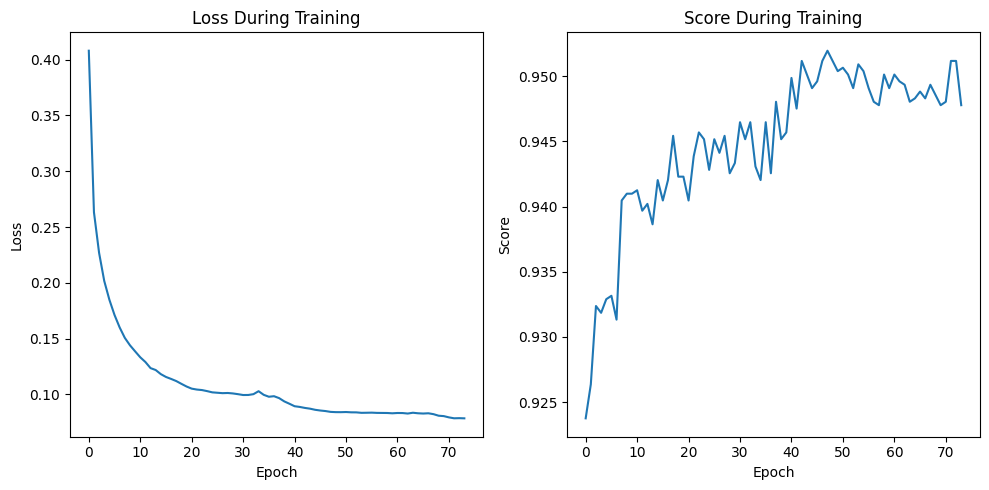

In [62]:
plt.figure(figsize=(10, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.loss_curve_)
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.validation_scores_)
plt.title('Score During Training')
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

### 8.3. Confusion Matrix

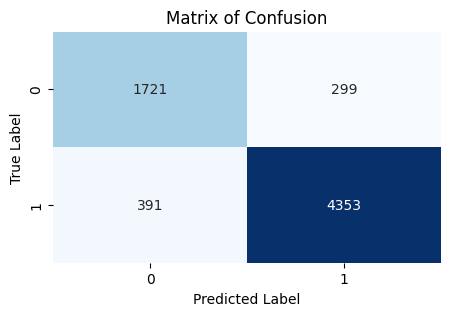

In [65]:
predictions = analyze_sentiment.predict(X_test)
conf_matrix = confusion_matrix(sentiment_test, predictions)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrix of Confusion')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 8.4. Curve ROC

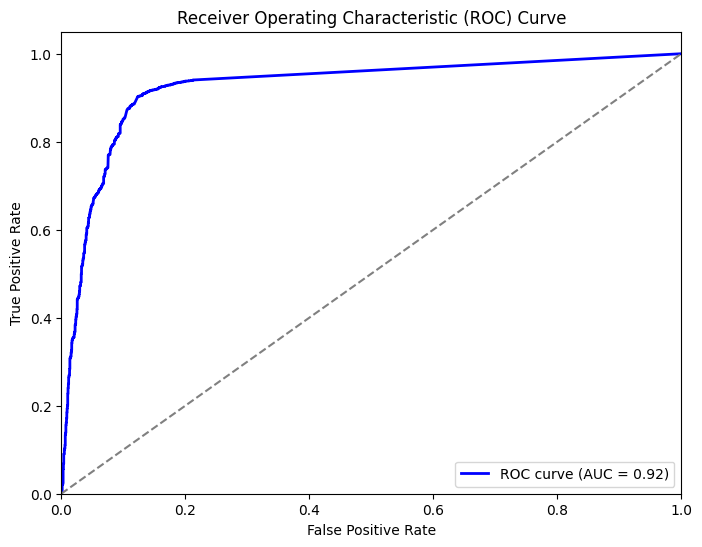

In [64]:
probas_pred = analyze_sentiment.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(sentiment_test, probas_pred)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 9. Deploy IA

In [113]:
# Save model MLPClassifier
joblib.dump(analyze_sentiment, 'modelo_analyze_sentiment.pkl')

# Save vectorizer
joblib.dump(vectorizer, 'vectorizer.pkl')

# Save normalization
joblib.dump(normalization, 'normalization.pkl')

['normalization.pkl']